In [5]:
# experiment tracker
sys.path.append('../../')
sys.path.append('../')
sys.path.append('../../experiment-impact-tracker/')

from experiment_impact_tracker.data_interface import DataInterface
from experiment_impact_tracker.data_utils import *

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [11]:
logdir = './logs/tmp/'  #track_sub_0128_benchmark' #/tmp/tmpcgbll4_7
compute_flops_csv = logdir + 'compute_costs_flop.csv'

log_df =  load_data_into_frame(logdir)
print('Number of samples in tracker log: {}'.format(len(log_df[1])))

flops_df = pd.read_csv(compute_flops_csv)
flops_df

Number of samples in tracker log: 766


,Unnamed: 0,task,start_time,duration,DP,MAC,params
0,0,setup,1.617225e+09,0.701908,779,0,0
1,3,Sagittal,1.617225e+09,3196.606068,27098,0,0
2,4,aggregate,1.617228e+09,10.010145,3811841493,0,0
3,5,cleanup,1.617228e+09,0.000022,1,0,0
4,6,save,1.617228e+09,0.385540,121,0,0


In [29]:
power_df

,timestamp,rapl_power_draw_absolute,rapl_estimated_attributable_power_draw
0,0.000000,31.403698,29.413631
1,4.103708,35.864061,34.920241
2,8.175727,36.000724,35.095068
3,12.259706,21.517713,20.122152
4,16.419756,14.724162,13.638014
...,...,...,...
761,3187.659776,14.976512,14.152391
762,3191.855774,14.927487,14.368689
763,3196.160269,13.227461,11.056002
764,3200.167852,10.091443,7.381819


In [35]:
power_df = log_df[0][['timestamp','rapl_power_draw_absolute','rapl_estimated_attributable_power_draw']]
power_df['timestamp'] = power_df['timestamp'] - power_df['timestamp'][0]

epochs = flops_df['start_time'] - flops_df['start_time'][0]

data_interface = DataInterface([logdir])
total_power = data_interface.total_power
total_carbon = data_interface.kg_carbon
PUE = data_interface.PUE
print('Experiment: {}\nduration: {:4.3} s, total power:{:4.3f} Watts, carbon: {:4.3f} kg, PUE: {}'.format(logdir.rsplit('/')[0], flops_df['duration'].sum(), total_power, total_carbon, PUE)) 

Experiment: .
duration: 3.21e+03 s, total power:0.020 Watts, carbon: 0.001 kg, PUE: 1.58


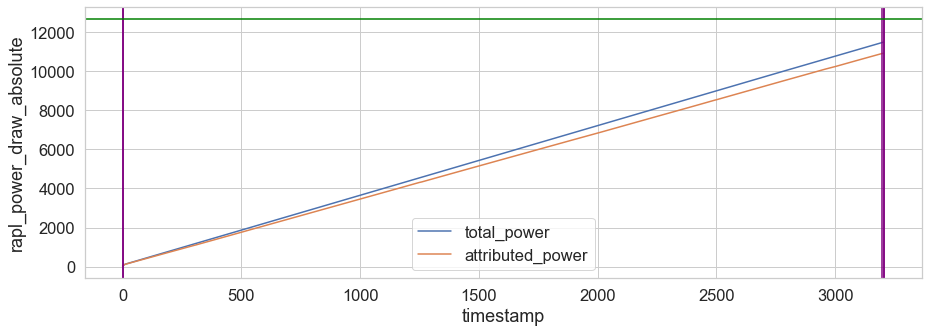

In [37]:
 sns.set(font_scale = 1.5)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(figsize=(15,5),sharex=False,sharey=False)

    g = sns.lineplot(power_df['timestamp'],power_df['rapl_power_draw_absolute'].cumsum(),label='total_power')
    g = sns.lineplot(power_df['timestamp'],power_df['rapl_estimated_attributable_power_draw'].cumsum(),label='attributed_power')

    for e in epochs:
        g = plt.axvline(e, linestyle='-',c='purple')
    
    g = plt.axhline(1000000*total_power/PUE, linestyle='-',c='green')
    
    plt.legend()


In [17]:
# experiment tracker
sys.path.append('../../')
sys.path.append('../')
sys.path.append('../../experiment-impact-tracker/')

from experiment_impact_tracker.compute_tracker import ImpactTracker
import tempfile
import time

def func1():
    count = 0
    for i in range(100):
        count += i
    return count

def func2():
    count = 0
    for i in range(100):
        count += i**2
    return count

In [2]:
experiment1 = tempfile.mkdtemp()
experiment2 = tempfile.mkdtemp()

print('Tracker 1')
tracker1  = ImpactTracker(experiment1)
print(tracker1.launched)
with tracker1:
    func1()
    print(tracker1.launched)

time.sleep(1)
print('Tracker 2')
tracker2  = ImpactTracker(experiment2)
print(tracker2.launched)
with tracker2:
    print('Starting context')
    print(tracker2.launched)
    print('Starting func2')
    func2()
    print(tracker2.launched)

INFO:Gathering system info for reproducibility...
Tracker 1
INFO:Requested http://ipinfo.io/json
INFO:Done initial setup and information gathering...
False
INFO:Requesting thread shutdown.
INFO:Starting process to monitor power
True
INFO:Starting - Logging final info.
INFO:Done - Logging final info.
INFO:Gathering system info for reproducibility...
Tracker 2
INFO:Done initial setup and information gathering...
experiment_impact_tracker.compute_tracker.ImpactTracker - ERROR - Encountered exception when launching power monitor thread.
experiment_impact_tracker.compute_tracker.ImpactTracker - ERROR - Encountered exception when launching power monitor thread.
ERROR:Encountered exception when launching power monitor thread.
--- Logging error ---
Traceback (most recent call last):
  File "../../experiment-impact-tracker/experiment_impact_tracker/compute_tracker.py", line 293, in launch_impact_monitor
    multiprocessing.set_start_method("fork")
  File "/home/nikhil/anaconda3/envs/green_compu

RuntimeError: context has already been set